In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch 07. 심장병 발병 예측 실습</font><b>

```
age 나이 (세)
sex 성별
    1 : 남성
    0 : 여성
cp (chest pain type) 가슴 통증(흉통) 타입
    1 : typical angina (전형적 협심증)
    2 : atypical angina (비전형적 협심증)
    3 : non-anginal pain (심장 관련이 아닌 흉통)
    4 : asymptomatic (증상 없음)
treshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)
    병원 처음 내원했을 때 잰 혈압이라고 보면 됨
chol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)
    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야
fbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부
    1 : 공복 혈당 120 초과 (고혈당)
    0 : 아니면 0
restecg (resting electrocardiographic results) 안정시 심전도 결과
    0 : 정상
    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)
    2 : LVH 가능성 (좌심실 비대 소견 등)
thalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수
exang (exercise induced angina) 운동으로 유발된 협심증 여부
    1 : 운동 시 흉통 있음
    0 : 없음
oldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)
    숫자가 클수록 보통 심장 허혈 가능성↑로 봄
slope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기
    1 : upsloping (상승형)
    2 : flat (평평)
    3 : downsloping (하강형)
ca 조영제(조영술)에서 보이는 주요 관상동맥 수 (0~3)
    0이면 문제 있는 관상동맥이 없는 것, 
    숫자가 클수록 문제 있는 혈관 수가 많다고 보면 됨
    여기에도 ? 값 좀 섞여 있음
hsl (보통 다른 데이터셋에서는 thal) 아마 **thalassemia 관련 검사 결과(thal)**를 의미
    3 : normal
    6 : fixed defect (고정 결손)
    7 : reversible defect (가역 결손)
    여기도 숫자가 이런 패턴이라, 같은 의미로 봐도 될 듯
heartDisease (target) 심장질환 유무 (목표 변수)
```

In [24]:
import pandas as pd
import numpy as np
import sys
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split #데이터 분리

# 1. 로지스틱회귀분석(이진분류)
1. 데이터셋 생성 & 전처리
    - 엑셀 → 데이터프레임 → '?' 처리(결측치로 전환하여 결측치 처리) → X, y 분리 
        → X변수의 scale 조정 → train_test_split() 이용하여 학습셋과 테스트셋 분리
2. 모델 생성 (입력 13, 출력1) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 혼동행렬==교차표)
4. 모델 사용/저장

## 1.1 데이터셋 생성 & 전처리

In [8]:
# anaconda prompt에서 ml-dl-nlp, pip install openpyxl
df = pd.read_excel('data/heart-disease.xlsx')
df.info()
# df.isnull().sum()
# Dtype object인 열에 ?문자가 있겠네?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [10]:
df.isin(['?']).sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [12]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl) : 7행
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]
#df[df['chol'].isin(['?'])]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [13]:
# ?를 결측치(np.nan)로 대체 → 결측치 처리(삭제)
df.replace('?', np.nan, inplace=True)

In [14]:
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [16]:
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [19]:
# 결측치 삭제
# 결측치 대체(fillna), 삭제(dropna)
df = df.dropna(how='any') #결측치가 한 열이라도 있으면 해당 행 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [21]:
# target 변수의 분포가 균형을 이루는지
df['heartDisease'].value_counts() /df.shape[0]

0    0.540541
1    0.459459
Name: heartDisease, dtype: float64

In [22]:
# 입력(독립) 변수와 타깃(종속) 변수 분리
X = df.iloc[:, :-1].values # 맨 마지막 열을 제외한 부분을 numpy array로
y = df.iloc[:, -1:].values # 맨 마지막 열을 numpy array로 "-1:" 마지막 행부터 마지막 행까지 (2차원으로) - train_test_split 사용 위해
X.shape, y.shape

((296, 13), (296, 1))

In [25]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [33]:
# scaled_X, y를 학습셋:테스트셋 = 7:3으로 분할
x_train, x_test, y_train, y_test = train_test_split(scaled_X, 
                                                    y,
                                                    test_size=0.3, #testset 비율
                                                    random_state=7,#randomness 고정
                                                    stratify=y) # y 기준으로 : 층화추출

In [34]:
# 심장병 양성/음성 비율
print(pd.DataFrame(y).value_counts(normalize=True))
print(pd.DataFrame(y_train).value_counts(normalize=True))
print(pd.DataFrame(y_test).value_counts(normalize=True))
# 층화추출하니 데이터 그룹 간 큰 비율 차이가 없음

0    0.540541
1    0.459459
dtype: float64
0    0.541063
1    0.458937
dtype: float64
0    0.539326
1    0.460674
dtype: float64


## 1.2. 모델 생성 (Input 13, Target 1) / 학습과정 설정
- 그래프를 보고, 과적합 심하면 이를 줄이는 과정을 추가할 수 있음 : Dropout 함수
- 모델 : 13 → 32 → 16 → 8 → 1

In [35]:
from tensorflow.keras.layers import Dropout

In [51]:
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                448       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 1)                

In [52]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall']) 
# precision, recall 위처럼 입력하면 에러
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='binary_crossentropy', 
              # optimizer=Adam(learning_rate=0.01), 
              optimizer='adam', 
              metrics=['accuracy', # 정확도
                       Precision(), # 정밀도(예측값 중심)
                       Recall()]) # 재현율(실제값 중심)

In [53]:
%%time
hist = model.fit(x_train, y_train, # 훈련 데이터셋
                 epochs=200, # 학습횟수
                 validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                 verbose=0) # 로그 출력

CPU times: total: 7.23 s
Wall time: 6.23 s


## 1.3. 모델평가(그래프, 평가, 교차표)

In [55]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3'])

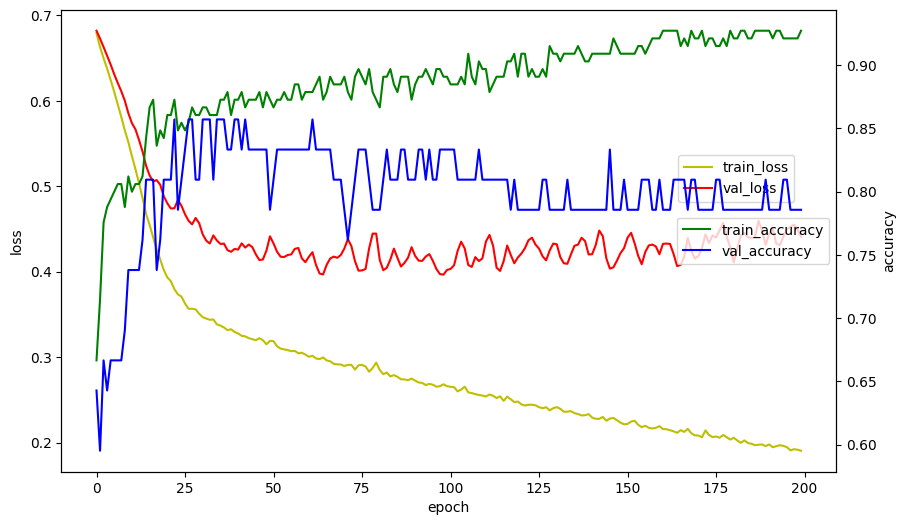

In [42]:
# 1차 그래프 (Dropout 적용 전)
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

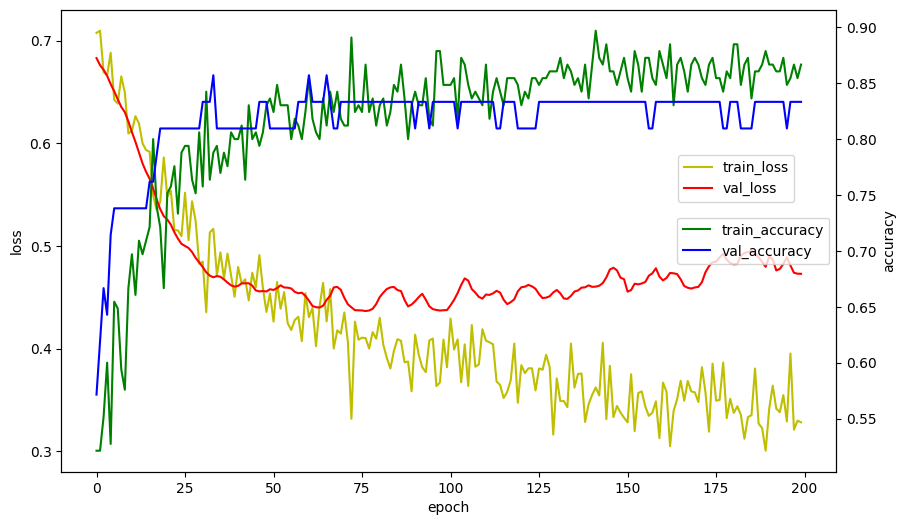

In [46]:
# 2차 그래프 (Dropout 적용 후)
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

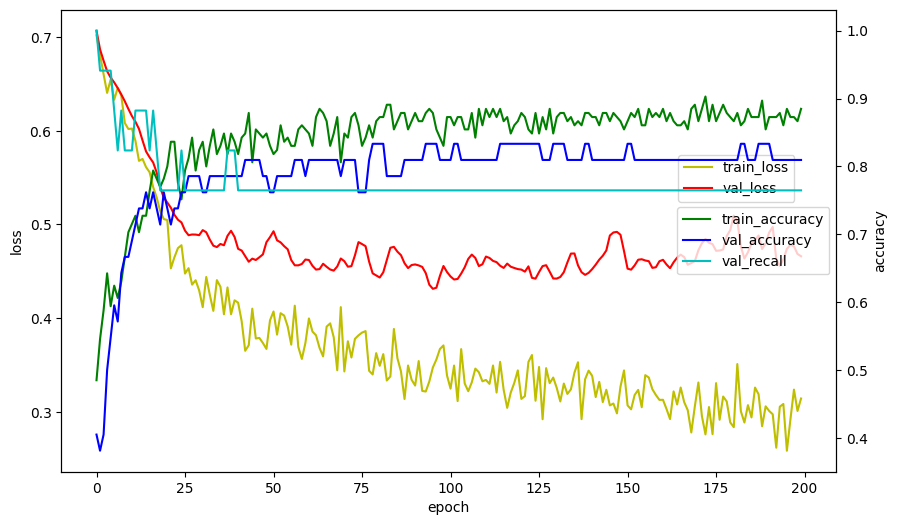

In [56]:
# 3차 그래프 (Dropout 조정 후)
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall_3'], 'c', label='val_recall')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [59]:
score = model.evaluate(x_test, y_test, verbose=0)
print('model loss: ', score[0])
print('model accuracy: ', score[1])
print('model precision: ', score[2])
print('model recall: ', score[3])

model loss:  0.5120453834533691
model accuracy:  0.8089887499809265
model precision:  0.800000011920929
model recall:  0.7804877758026123


In [61]:
#교차표
y_hat = (model.predict(x_test) >= 0.5).astype(int)
y_test.shape, y_hat.shape #실제값:1차원, 예측값:2차원

3/3 [==============================] - 0s 5ms/step


((89, 1), (89, 1))

In [65]:
pd.crosstab(y_test.reshape(-1), #실제값
            y_hat.reshape(-1), #예측값
            rownames=['실제값'], #index이름
            colnames=['예측값']) #column이름

예측값,0,1
실제값,,
0,40,8
1,9,32


In [69]:
#모델사용
print(x_test[0])
print(x_test[1])

[0.58333333 1.         1.         0.52830189 0.34246575 0.
 1.         0.3129771  1.         0.09677419 0.5        0.33333333
 0.75      ]
[0.125      1.         1.         0.30188679 0.35616438 0.
 1.         0.64885496 1.         0.         0.         0.
 1.        ]


In [70]:
print((model.predict([[0.58333333, 1, 1, 0.52830189, 0.34246575, 0, 1, 0.3129771, 1, 0.09677419, 0.5, 0.33333333, 0.75]]) >= 0.5).astype(int))
print(y_test[0])
print((model.predict([[0.125, 1, 1, 0.30188679, 0.35616438, 0, 1, 0.64885496, 1, 0, 0, 0, 1]]) >= 0.5).astype(int))
print(y_test[1])

1/1 [==============================] - 0s 44ms/step
[[1]]
[1]
1/1 [==============================] - 0s 34ms/step
[[1]]
[1]


In [71]:
#저장하기
model.save('model/07_heartdisease_logistic.h5')

# 2. 분류분석
x_train, x_test, y_train, y_test
- y_train, y_test 원핫인코딩

## 2.1. 데이터셋

In [72]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((207, 13), (89, 13), (207, 1), (89, 1))

In [73]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((207, 2), (89, 2))

In [74]:
print('원 데이터:\n', y_train[:3])
print('원핫인코딩 데이터:\n', Y_train[:3])

원 데이터:
 [[0]
 [1]
 [0]]
원핫인코딩 데이터:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


## 2.2. 모델 생성, 학습
13 → 32 → 16 → 8 → 2

In [87]:
model = Sequential()
model.add(Dense(units=32, input_shape=(13,), activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                448       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                272       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 2)                

In [88]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall()])

In [89]:
hist = model.fit(x_train, Y_train, 
                 epochs=200, 
                 validation_split=0.2, 
                 verbose=0)

## 2.3. 모델 평가

In [90]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_6', 'recall_6', 'val_loss', 'val_accuracy', 'val_precision_6', 'val_recall_6'])

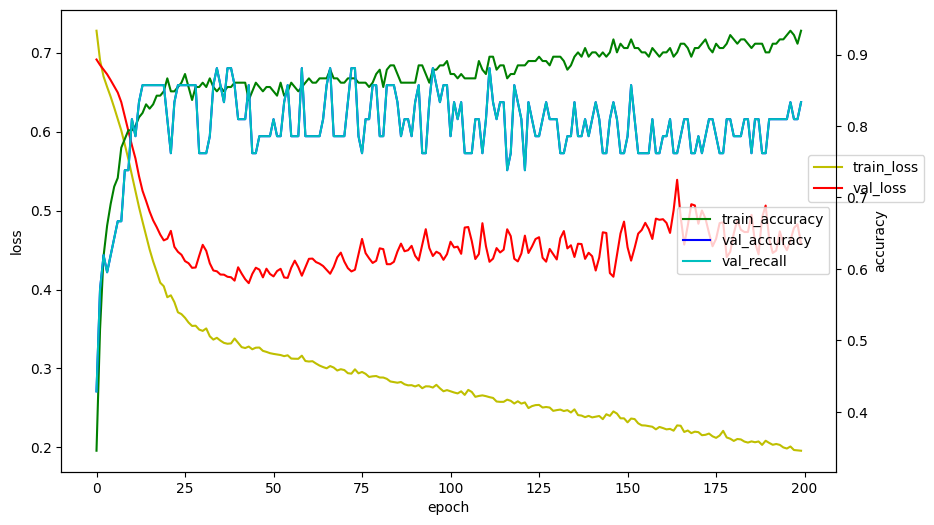

In [79]:
# 1차 그래프 (Dropout 입력 전)
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall_4'], 'c', label='val_recall')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

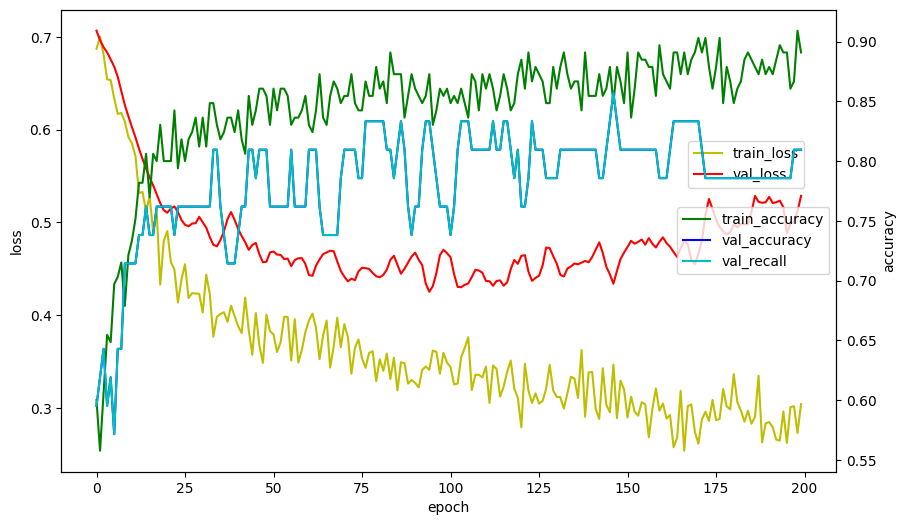

In [86]:
# 2차 그래프 (Dropout 입력 후 (0.2/0.2/0.2))
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall_5'], 'c', label='val_recall')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.8, 0.6))
acc_ax.legend(loc='center right')
plt.show()

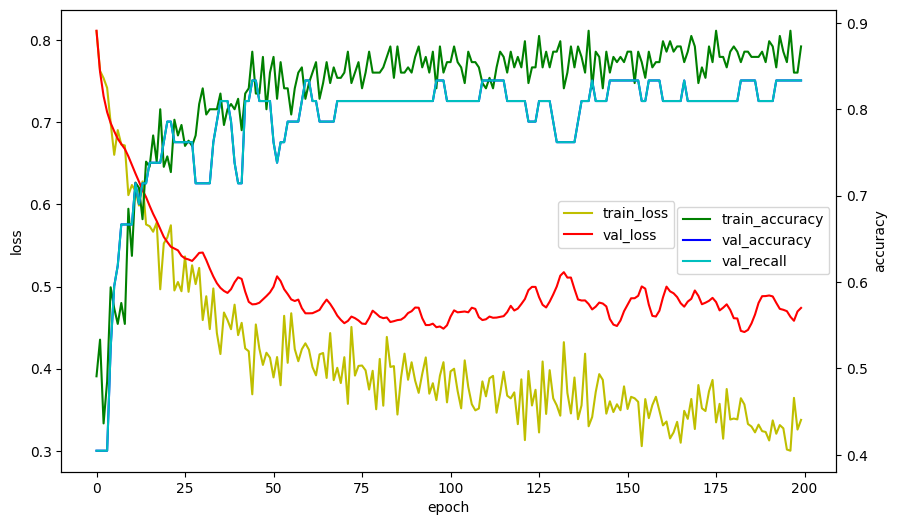

In [91]:
# 3차 그래프 (Dropout 강화 후 (0.3/0.3/0.3))
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall_6'], 'c', label='val_recall')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.8, 0.6))
acc_ax.legend(loc='center right')
plt.show()

In [96]:
x_test.shape, Y_test.shape

((89, 13), (89, 2))

In [95]:
score = model.evaluate(x_test, Y_test, verbose=0)
print('model loss: ', score[0])
print('model accuracy: ', score[1])
print('model precision: ', score[2])
print('model recall: ', score[3])

model loss:  0.5402001142501831
model accuracy:  0.7977527976036072
model precision:  0.7977527976036072
model recall:  0.7977527976036072


In [107]:
y_hat = model.predict(x_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 0s/step


array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [113]:
pd.crosstab(y_test.reshape(-1,), y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0,39,9
1,9,32


In [116]:
# 모델 사용
print((model.predict([[0.58333333, 1, 1, 0.52830189, 0.34246575, 0, 1, 0.3129771, 1, 0.09677419, 0.5, 0.33333333, 0.75]]) >= 0.5).astype(int))
print(y_test[0])
print((model.predict([[0.125, 1, 1, 0.30188679, 0.35616438, 0, 1, 0.64885496, 1, 0, 0, 0, 1]]) >= 0.5).astype(int))
print(y_test[1])

1/1 [==============================] - 0s 33ms/step
[[0 1]]
[1]
1/1 [==============================] - 0s 37ms/step
[[0 1]]
[1]


In [117]:
#저장하기
model.save('model/07_heartdisease_classifying.h5')